In [1]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [2]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

In [3]:
df_jeux_up.head()

,Nombre d'avis,Note,categories,description,titre,_id,creators,illustrators,editors,distributors,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,7.58,NaN,\n Marvel United : Unis c...,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,45.0,0,1,1,1,0,1
1,33.0,7.39,NaN,"\n Chaque année, au print...",Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,60.0,0,1,1,0,1,1
2,28.0,8.18,Enchères|Aventures dans la jungle|Collection /...,\n Vous êtes à la tête d’...,Quetzal,quetzal,Alexandre Garcia,Nastya Lehn,Gigamic,NaN,45.0,0,1,1,0,1,1
3,4.0,9.00,NaN,\n Un Kit de démarrage co...,Alien - Kit de Démarrage,alien-kit-de-demarrage,NaN,NaN,Arkhane Asylum Publishing,NaN,NaN,0,1,1,1,0,1
4,72.0,8.75,Card-driven|Combinaison|Coopération|Deck build...,\n Le Dr Foo a créé une t...,The LOOP,the-loop,Maxime Rambourg et Théo Rivière,Simon Caruso,Catch Up Games,NaN,60.0,0,1,1,1,0,1


# II. Nettoyage des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [4]:
jeux_cat = df_jeux_up.apply(traitement.extract_categories, axis=1)

In [5]:
jeux_cat

0                                                       []
1                                                       []
2        [Enchères, Aventures dans la jungle, Collectio...
3                                                       []
4        [Card-driven, Combinaison, Coopération, Deck b...
                               ...                        
16868                                    [Jeux de plateau]
16869                                     [Jeux de guerre]
16870                                     [Jeux de guerre]
16871                                     [Jeux de guerre]
16872                                     [Jeux de cartes]
Length: 16873, dtype: object

In [6]:
cats = []
jeux_cat.map(cats.extend)
u_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
u_cats     = u_cats[index]

In [7]:
print(f"{len(u_cats)} tag de categories")

184 tag de categories


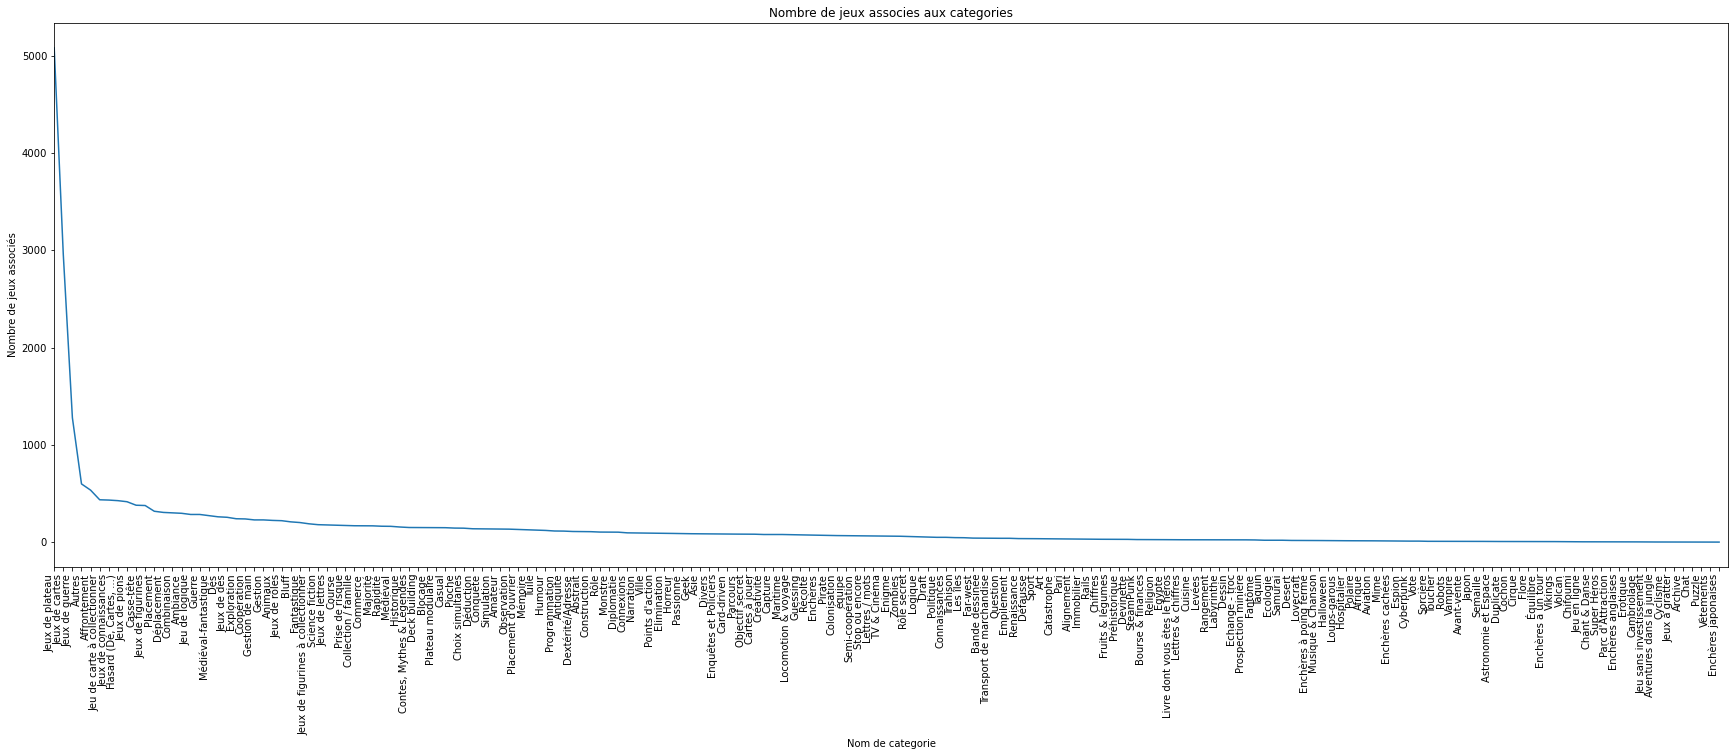

In [8]:
plt.figure(figsize=(30, 10))
plt.plot(u_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(u_cats)))
plt.show()

In [9]:
# Installer les ressources nécessaires

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

# import spacy
# spacy.cli.download("fr_core_news_lg")

On nettoie les catégories en supprimant les ponctuations, caractères spéciaux, les stops word ....

In [10]:
c_cats = []

for cat in u_cats:
    cat_ = preprocessing.clean_text(cat)
    cat_tokens = preprocessing.tokenize_text(cat_)    
    cat_tokens = preprocessing.remove_stopwords(cat_tokens)
    cat_tokens = preprocessing.lemmatize_tokens(cat_tokens)
    cat_ = " ".join(cat_tokens)
    c_cats.append(cat_)

#### Mise à jour des categories des jeux

Remplacer les catégories par leur version nettoyée

In [11]:
jeux_cat_up = jeux_cat.copy()

for i, row in jeux_cat.iteritems():
    row_ = []
    
    for cat in row:
        index = np.where(u_cats == cat)[0][0]
        row_.append(c_cats[index])
        
    jeux_cat_up[i] = np.unique(row_)
    
jeux_cat_up.head()

0                                                   []
1                                                   []
2    [aventure jungle, collection famille, enchere,...
3                                                   []
4    [card driven, combinaison, cooperation, deck b...
dtype: object

#### Suppression de la catégorie `autre` :

In [12]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 599


In [13]:
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("autre").__ne__, l))))
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("").__ne__, l))))

In [14]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 0


In [15]:
jeux_cat_up = jeux_cat_up.map(lambda x: np.NAN if len(x) == 0 else x)

In [17]:
df_jeux_up["categories"] = jeux_cat_up.map(lambda x : ",".join(x) if type(x) != float else x)

In [19]:
df_jeux_up["categories"]

0                                                      NaN
1                                                      NaN
2        aventure jungle,collection famille,enchere,exp...
3                                                      NaN
4        card driven,combinaison,cooperation,deck build...
                               ...                        
16868                                              plateau
16869                                               guerre
16870                                               guerre
16871                                               guerre
16872                                                carte
Name: categories, Length: 16873, dtype: object

In [18]:
df_jeux_up.to_csv('../data/details_clean_cat.csv', index=False)